# Distributed Ridge Regression
## Define the graph network deployment server process

In [12]:
def graph_server() -> None:
    from numpy import array, eye
    from logging import basicConfig, INFO
    from topolink import Graph

    basicConfig(level=INFO)

    L = array([[2, -1, 0, -1], [-1, 2, -1, 0], [0, -1, 2, -1], [-1, 0, -1, 2]])
    W = eye(4) - L * 0.2

    graph = Graph.from_mixing_matrix(W, address="localhost:5555")
    graph.deploy()

## Define the computation node for distributed ridge regression

In [ ]:
from numpy import float64
from numpy.typing import NDArray


def ridge_regression(
    algorithm: str,
    u_i: NDArray[float64],
    v_i: NDArray[float64],
    name: str,
    dim_i: int,
    rho_i: float,
    gamma: float,
    max_iter: int = 500,
    server_address: str = "localhost:5555",
) -> NDArray[float64]:
    from dco import Optimizer, LocalObjective

    def f(var: NDArray[float64]) -> NDArray[float64]:
        return (u_i @ var - v_i) ** 2 + rho_i * var @ var

    local_obj = LocalObjective(dim_i, f)

    optimizer = Optimizer.create(
        name, local_obj, gamma, algorithm=algorithm, server_address=server_address
    )

    history = optimizer.solve_sync(max_iter, with_history=True)

    return history

## Define parameters and run centralized optimization
The problem is defined as

$$
\min_{x \in \mathbb{R}^d} \quad \frac{1}{4} \sum_{i = 1}^4 (u_i^\top x - v_i)^2 + \rho \| x \|^2
$$

where the solution is denoted as $x^*$.

In [14]:
if __name__ == "__main__":
    dim = 10

    # Should be consistent with the definition in the graph server
    n_nodes = 4
    nodes = [str(i) for i in range(1, n_nodes + 1)]

    from numpy import multiply, ones
    from numpy.random import seed, uniform, normal

    seed(0)

    rho = 0.01
    u = {i: uniform(-1, 1, dim) for i in nodes}
    x_tilde = {i: multiply(0.1 * (int(i) - 1), ones(dim)) for i in nodes}
    epsilon = {i: normal(0, 5) for i in nodes}
    v = {i: u[i] @ x_tilde[i] + epsilon[i] for i in nodes}

    import cvxpy as cp

    x = cp.Variable(dim)

    loss = cp.sum([(u[i] @ x - v[i]) ** 2 for i in nodes]) / n_nodes
    regularizer = rho * cp.sum_squares(x)

    prob = cp.Problem(cp.Minimize(loss + regularizer))
    prob.solve(cp.OSQP)

    x_star: NDArray[float64] = x.value  # type: ignore

## Benchmark distributed optimization algorithms
In this section, we benchmark the distributed optimization algorithms `EXTRA`, `NIDS`, `DIGing`, `AugDGM`, `WE`, and `RGT` on the ridge regression problem.
Each algorithm is executed with its respective step size, and their performance is compared in terms of mean squared error (MSE)

$$
\frac{1}{4d} \sum_{i = 1}^{4} || x_i - x^* ||^2
$$

over iterations, where $x_i, x^* \in \mathbb{R}^d$.

In [15]:
from multiprocessing import Pool

if __name__ == "__main__":
    step_sizes = {
        "EXTRA": 0.16,
        "NIDS": 0.21,
        "DIGing": 0.11,
        "AugDGM": 0.31,
        "WE": 0.17,
        "RGT": 0.11,
    }

    local_histories: dict[str, list[NDArray[float64]]] = {}

    with Pool(processes=n_nodes + 1) as pool:
        for algorithm, step_size in step_sizes.items():
            tasks = [
                pool.apply_async(
                    ridge_regression,
                    args=(algorithm, u[i], v[i], i, dim, rho, step_size),
                )
                for i in nodes
            ]

            pool.apply_async(graph_server, args=())

            local_histories[algorithm] = [task.get() for task in tasks]

INFO:topolink.Graph:Server running on 192.168.2.8:5555
INFO:topolink.Graph:Node 4 registered with address 192.168.2.8:44701
INFO:topolink.Graph:Node 2 registered with address 192.168.2.8:44631
INFO:topolink.Graph:Node 3 registered with address 192.168.2.8:45327
INFO:topolink.Graph:Node 1 registered with address 192.168.2.8:46181
INFO:topolink.Graph:All nodes registered. Server is now ready.
INFO:topolink.Graph:Sent neighbor information to all nodes.
INFO:topolink.Graph:Node 3 has unregistered.
INFO:topolink.Graph:Node 2 has unregistered.
INFO:topolink.Graph:Node 1 has unregistered.
INFO:topolink.Graph:Node 4 has unregistered.
INFO:topolink.Graph:Server running on 192.168.2.8:5555
INFO:topolink.Graph:Node 2 registered with address 192.168.2.8:46241
INFO:topolink.Graph:Node 4 registered with address 192.168.2.8:45779
INFO:topolink.Graph:Node 3 registered with address 192.168.2.8:45265
INFO:topolink.Graph:Node 1 registered with address 192.168.2.8:46547
INFO:topolink.Graph:All nodes regis

## Plot the results

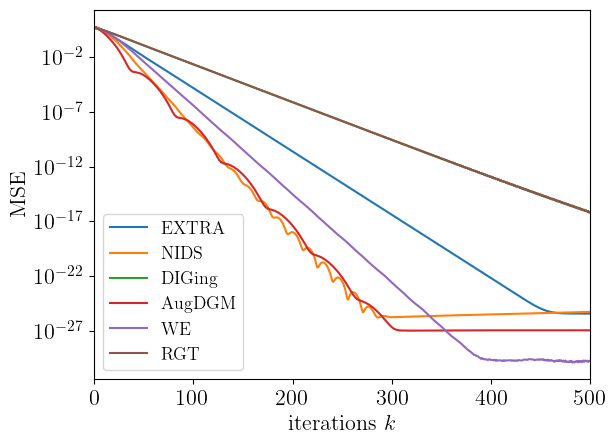

In [16]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    from numpy import mean

    plt.rcParams["text.usetex"] = True
    plt.rcParams["font.family"] = "serif"

    plt.rcParams.update(
        {
            "font.size": 14,
            "axes.titlesize": 16,
            "axes.labelsize": 16,
            "xtick.labelsize": 16,
            "ytick.labelsize": 16,
            "legend.fontsize": 13,
        }
    )

    fig, ax = plt.subplots()

    for algorithm, histories in local_histories.items():
        avg_history = mean(histories, axis=0)
        mse_evolution = mean((avg_history - x_star) ** 2, axis=1)

        ax.semilogy(mse_evolution, label=algorithm)

    ax.set_xlim((0, 500))
    ax.set_xlabel("iterations $k$")
    ax.set_ylabel("MSE")
    ax.legend()

    plt.show()